# Package that we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal

# you can choose one of the following package for image reading/processing

import cv2
from PIL import Image

## 1 Support Vector Machine

<style>
.blue{
    color: skyblue;
}
.bold{
    font-weight: bold;
}
</style>

In the training procedure of SVM, we need to optimize with respect to the Lagrange multipliers
$a = \{ a_n \}$. 

Here, we use the <span class="blue">sequential minimal optimization</span> to solve the problem. 

For details, you can refer to the paper [Platt, John. “Sequential minimal optimization: 

A fast algorithm for training support vector machines”, 1998]. The classifier is written by

$$
    y(\textbf{x}) = \sum_{n=1}^N a_n t_n k(\textbf{x}, \textbf{x}_n) = \textbf{w}^T \textbf{x} + b
$$
$$
    \textbf{w} = \sum_{n=1}^N \alpha_n t_n \phi(\textbf{x}_n)
$$
$$
    b = \frac{1}{N_{\mathcal{M}}} \sum_{n \in \mathcal{M}} \left( t_n - \sum_{m \in \mathcal{S}} a_m t_m k(\textbf{x}_n, \textbf{x}_m) \right)
$$

where $\mathcal{M}$ denotes the set of indices of data points having $0 \lt a_n \lt C$.

### 1.1

It is popular to use principal component analysis (PCA) to reduce the dimension of images to d = 2. 

Please implement it by yourself instead of using the method from sklearn.

In [2]:
data = pd.read_csv("./x_train.csv",header= None)/255
label = pd.read_csv("./t_train.csv",header= None)

**PCA**

$\textbf{C}$ is covariance matrix of $\textbf{X}$, $\textbf{W}$ is the eigenvector matrix of $\textbf{C}$, $\Lambda$ is the eigenvalue matrix of $\textbf{C}$.

$\textbf{X}$ is the data matrix, $\textbf{X}_k$ is the data matrix after dimension reduction, and k in this task will be 2.

$$
    \textbf{C} = \frac{\textbf{X}^T \textbf{X}}{n - 1}
$$
$$
    \textbf{C} = \textbf{W} \Lambda \textbf{W}^{-1}
$$
$$
    \textbf{X}_k = \textbf{X} \textbf{W}_k
$$

**Using SVD to solve PCA**

$\Sigma$ is the singular value matrix of $\textbf{X}$, $\textbf{U}$ is the left singular vector matrix of $\textbf{X}$, $\textbf{V}$ is the right singular vector matrix of $\textbf{X}$.

$$
    \textbf{C} = \frac{\textbf{X}^T \textbf{X}}{n - 1} 
$$
$$
    \textbf{C} = \frac{\textbf{V}\Sigma\textbf{U}^T\textbf{U}\Sigma\textbf{V}^T}{n - 1}
$$
$$
    \textbf{C} = \textbf{V} \frac{\Sigma^2}{n - 1}\textbf{V}^T
$$
$$
    \textbf{C} = \textbf{V} \frac{\Sigma^2}{n - 1}\textbf{V}^{-1} \ \ (\rm{because} \ \textbf{V} \ \rm{is \ unitary})
$$

We can found that covariance matrix $\textbf{C}$ is the same as the eigenvalue matrix $\Lambda$ of $\textbf{V}^{-1}$.

$$
    \Lambda = \frac{\Sigma^2}{n - 1}
$$

<center>
    <img src = "./image/pca.png">
</center>

In [3]:
data_new = data.values - np.mean(data.values, axis=0) # centralize data
np.allclose(data_new.mean(axis=0), np.zeros(data_new.shape[1])) # check if centralization is correct
C = (data_new.T @ data_new) / (data_new.shape[0] - 1) # covariance matrix
eig_vals, eig_vecs = np.linalg.eig(C) # eigenvalues and eigenvectors
eig_vals, eig_vecs = eig_vals.real, eig_vecs.real # convert to real numbers
# sort eigenvalues in ascending order   
eig_vals_sorted = np.argsort(eig_vals)[::1][-2:] # sort eigenvalues in ascending order and take the last two
data_pca = data_new @ eig_vecs[:,eig_vals_sorted] # PCA

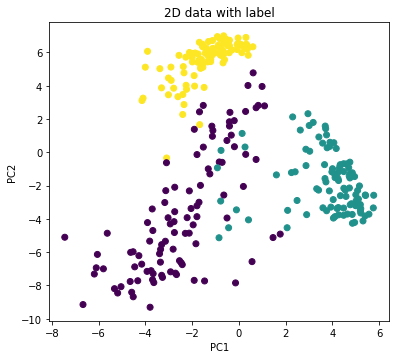

In [12]:
# plot 2D data with label and resize the figure
x_min, x_max = data_pca[:, 0].min() - 1, data_pca[:, 0].max() + 1
y_min, y_max = data_pca[:, 1].min() - 1, data_pca[:, 1].max() + 1
plt.figure(figsize=((x_max-x_min) * 0.4,(y_max-y_min) * 0.3))
plt.scatter(data_pca[:,0],data_pca[:,1],c=label.values)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D data with label')
plt.show()

#### 1.2

Describe the difference between two decision approaches (one-versus-the-rest and one-
versus-one). 

Decide which one you want to choose and explain why you choose this approach.

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

**One-versus-the-rest**

First, we train a binary classifier <span class="red">for each class</span>. 

Only one class is positive and the rest are negative.

Then, we use the classifier to predict the class of the test data. 

Finally, we choose the class with the highest score.

**One-versus-one**

We train a binary classifier <span class="red">for each pair of classes</sapn>. 

Then, we use the classifier to predict the class of the test data. 

The test data is assigned to the class that wins the most duels.

Finally, we choose the class with the highest score.

**Which one to choose**

Support vector machine is a binary classifier.

If we use one-versus-the-rest, we need to train $C$ binary classifiers.

If we use one-versus-one, we need to train $\frac{C(C-1)}{2}$ binary classifiers.

If $C$ is large, <span class = "red">one-versus-one is better</sapn>.

#### 1.3

<style>
.blue{
    color: skyblue;
}
.bold{
    font-weight: bold;
}
</style>

Use the principle values projected to top <span class="blue">two</span> eigenvectors obtained from PCA, and build
a SVM with <span class="blue">linear kernel</span> to do multi-class classification. 

You can decide the upper bound $C$ of $a_n$ by yourself or just use the default value provided by sklearn. 

Then, <span class="blue">plot the corresponding decision boundary</span> and show the <span class="blue">support vectors.</span>

* Linear kernel:
$$
    k(\textbf{x}_i, \textbf{x}_j) = \phi(\textbf{x}_i)^T \phi(\textbf{x}_j) = \textbf{x}_i^T \textbf{x}_j
$$

The sample figures are provided below.

<center>
    <img src = "./image/figure1.png" width = 50%>
</center>

<br><br>

* cvxopt.solvers.qp

$$
    \begin{aligned}
        \min \ & \frac{1}{2} \textbf{x}^T \textbf{P} \textbf{x} + \textbf{q}^T \textbf{x} \\
        \text{s.t. \ } & \textbf{G} \textbf{x} \leq \textbf{h} \\
        & \textbf{A} \textbf{x} = \textbf{b} \\
        & s \succeq 0
    \end{aligned}

$$

<center>
    <img src="./image/svm_linear.png" width=50%>
</center>

In [5]:
class SVM (object):
    def __init__(self, kernel='linear', C=1.0, gamma='auto'):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.alpha = None
        self.b = None
        self.support_vector = None
        self.support_vector_label = None
        self.support_vector_alpha = None

    def _kernel(self, x1, x2):
        if self.kernel == 'linear':
            return x1 @ x2.T
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)
        elif self.kernel == 'poly':
            return (1 + x1 @ x2.T) ** self.gamma
        else:
            raise ValueError('kernel not supported')

    def fit(self, x, y):
        n_samples, n_features = x.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel(x[i], x[j])

        # cvxopt matrices using numpy
        P = np.outer(y, y) * K
        q = -1 * np.ones(n_samples)
        G = np.diag(np.ones(n_samples) * -1)
        h = np.zeros(n_samples)
        A = y.reshape(1, n_samples)
        b = np.zeros(1)
        # solve QP problem using numpy
        a = np.linalg.solve(np.dot(G, P) + np.eye(n_samples), np.dot(G, q))

        # Lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.alpha = a[sv]
        self.support_vector = x[sv]
        self.support_vector_label = y[sv]

        # Intercept
        self.b = 0
        for n in range(len(self.alpha)):
            self.b += self.support_vector_label[n]
            self.b -= np.sum(self.alpha * self.support_vector_label * K[ind[n], sv])
        self.b /= len(self.alpha)

        # Weight vector
        if self.kernel == 'linear':
            self.w = np.zeros(n_features)
            for n in range(len(self.alpha)):
                self.w += self.alpha[n] * self.support_vector_label[n] * self.support_vector[n]
        else:
            self.w = None

    def predict(self, x):
        if self.w is not None:
            return np.sign(x @ self.w + self.b)
        else:
            y_predict = np.zeros(len(x))
            for i in range(len(x)):
                s = 0
                for alpha, sv_y, sv in zip(self.alpha, self.support_vector_label, self.support_vector):
                    s += alpha * sv_y * self._kernel(x[i], sv)
                y_predict[i] = s
            return np.sign(y_predict + self.b)

    def score(self, x, y):
        y_predict = self.predict(x)
        return np.mean(y_predict == y)

In [6]:
# plot decision boundary
def plot_decision_boundary(X, y, clf, h=0.02, cmap=plt.cm.Spectral, name='linear'):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    plt.title('Decision Boundary using ' + name + ' kernel')
    plt.show()

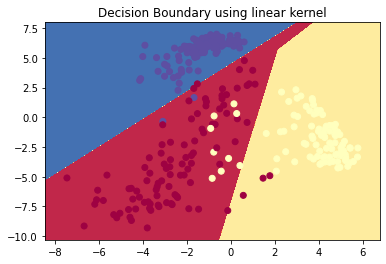

In [7]:
input_y = label.values.flatten()
clf = svm.SVC(kernel='linear', C=1)
clf.fit(data_pca, input_y)
model_s = SVM(kernel='linear', C=1)
model_s.fit(data_pca, input_y)
model_s.score(data_pca, input_y)

plot_decision_boundary(data_pca, input_y, clf, name='linear')

#### Bonus

<style>
.blue{
    color: skyblue;
}
.bold{
    font-weight: bold;
}
</style>

Repeat 3 with <span class="blue">polynomial kernel (degree = 2).</span>

* Polynomial (homogeneous) kernel of degree 2:

$$
    k(\textbf{x}_i, \textbf{x}_j) = \phi(\textbf{x}_i)^T \phi(\textbf{x}_j) = \left( \textbf{x}_i^T \textbf{x}_j\right)^2
$$
$$
    \phi(\textbf{x}) = \left[ \textbf{x}_1^2, \sqrt{2} \textbf{x}_1 \textbf{x}_2, \textbf{x}_2^2 \right]
$$
$$
    \textbf{x} = \left[ x_1, x_2 \right]
$$

<center>
    <img src="./image/svm_poly.png" width=50%>
</center>

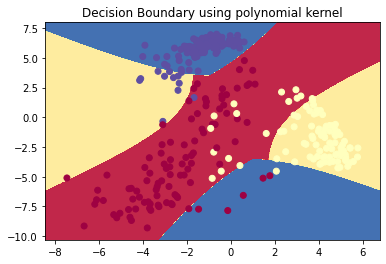

In [8]:
input_y = label.values.flatten()
# support vector machine with polynomial kernel (degree 2)
clf = svm.SVC(kernel='poly', degree=2, C=1)
clf.fit(data_pca, input_y)
model_s = SVM(kernel='poly', gamma=2, C=1)
model_s.fit(data_pca, input_y)
model_s.score(data_pca, input_y)

plot_decision_boundary(data_pca, input_y, clf, name='polynomial')

## 2 Gaussian Mixture Model

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

In this exercise, you will implement a Gaussian mixture model (GMM) and apply it in image segmentation. 

First, use a $K$-means algorithm to find $K$ central pixels. 

Second, use the expectation maximization (EM) algorithm <span class="blue">(please refer to textbook p.438-p.439)</span> to optimize the parameters of the model. 

The input image is given by <span class="red">hw3.jpg</span>. 

According to the maximum likelihood, you can decide the color $\mu_k$ , $k \in [1, . . . , K]$ of each pixel $x_n$ of output image

#### 2.1

Please build a $K$-means model by minimizing

$$
    J = \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk} \| x_n - \mu_k \|^2
$$

and show the table of the estimated $\{ \mu_k \}^K_{k=1}$.

In [13]:
np.random.seed(42)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KMeans():
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []
        
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        # initialize 
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()
            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break
            if self.plot_steps:
                self.plot()
        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)
    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels
    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index
    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)
        for point in self.centroids:
            ax.scatter(*point, marker="x", color='black', linewidth=2)
        plt.show()
    def cent(self):
        return self.centroids

In [14]:
image = cv2.imread("./hw3.jpg")

def kmeans_preprocess(image):
    # convert image to 2D array
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    return pixel_values

def gmm_preprocess(image):
    # convert image to 2D array
    pixel_values = image.reshape((-1, 3))
    pixel_values = pixel_values/255
    return pixel_values

In [22]:
k_slot = [2, 3, 7, 20]
for k_idx in k_slot:
    k = KMeans(K=k_idx, max_iters=100)
    print("K = ", k_idx)
    pixel_values = kmeans_preprocess(image)
    y_pred = k.predict(pixel_values)
    centers = np.uint8(k.cent())
    # print center values with RGB format
    y_pred = y_pred.astype(int)
    labels = y_pred.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    centers_table = pd.DataFrame(centers, columns=["R", "G", "B"])
    print(centers_table)
    print("*" * 50)

K =  2
     R    G    B
0   29   60   28
1  133  155  153
**************************************************
K =  3
     R    G    B
0  154  170  189
1   77  109   67
2   19   50   22
**************************************************
K =  7
     R    G    B
0   31   72   33
1   81  111   70
2  121  141  168
3   16   39   18
4  114  145   95
5  165  179  203
6  208  216  236
**************************************************
K =  20
      R    G    B
0    86   97   88
1    76   94  104
2   115  151   89
3    24   65   26
4    86  121   64
5    97  132   73
6    73  104   50
7   147  164  189
8    25   85   38
9   114  132  154
10   86  109  135
11   65   95   47
12   12   25   15
13  197  207  228
14   18   49   20
15   39   57   65
16   52   80   35
17   53   80  107
18   80  112   57
19   16   36   16
**************************************************


[$\mu_k$ , $k \in [1, . . . , K]$](./KMeans_mu.txt)

#### 2.2

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

Use $ \mu = \{ \mu_k \}^K_{k=1}$ calculated by the $K$-means model as the means, and calculate the corresponding variances $ \sigma_k^2 $ 

and mixing coefficient $\pi_k$ for the initialization of the GMM $p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x \ | \ \mu_k, \sigma_k^2)$.

Optimize the model by maximizing the log likelihood function $\log \ p(x \ | \ \pi, \mu, \sigma^2)$ over N pixels through EM algorithm. 

<span class="red">Plot the learning curve for log likelihood of GMM.</span> <span class="blue">(Please terminate EM algorithm when the number of iterations arrives at 100.)</span>

In [16]:
class GaussianMixture:
    """Gaussian Mixture Model
    initial centrol using k-meas solution.
    """
    def __init__(self, k=3, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        self.loglikelihood = []
        
    def init(self, X, parameters=None):
        self.X = X 
        self.sample_size, self.n_features = X.shape # (76480, 3)
        
        if parameters is not None:
            centroid, labels = parameters
            pi = [np.mean(labels == k) for k in range(self.k)] # (3, )
            mu = centroid # (3, 3)
            cov = [np.cov(X[np.where(labels==k)[0]].T) for k in range(self.k)] # (3, 3, 3)
        
        return np.array(pi), np.array(mu), np.array(cov)
    
    def EM(self, pi, mu, cov):
        
        # initialization
        self.pi, self.mu, self.cov = pi, mu, cov
        
        for n_iter in range(self.max_iter):
            # E step
            self._resp, self.likelihood = self._e_step(self.pi, self.mu, self.cov)
            # M step
            self.pi, self.mu, self.cov = self._m_step(self._resp)
            # recode log likelihood
            self.recode_likelihood(self.likelihood)
            
        return self.likelihood
            
    def _e_step(self, pi, mu, cov):
        # calculate likelihood
        likelihood = np.array([multivariate_normal.pdf(self.X, mean=mu[k], cov=cov[k], allow_singular=True) for k in range(self.k)]) # (3, 76480)
        resp = np.array(likelihood / np.sum(likelihood, axis=0)).T # (76480, 3)
        return resp, likelihood
    
    def _m_step(self, resp):
        N_k = np.sum(resp, axis=0) # (3,)
        pi = N_k / self.sample_size # (3,)
        mu = np.dot(resp.T, self.X) /  N_k[:, np.newaxis] # (3, 3)
        cov = [ (1/N_k[k]) * np.dot((resp[:, k, np.newaxis]*(self.X - mu[k])).T, (self.X - mu[k]))  for k in range(self.k)]
        return pi, mu, cov
        
    def recode_likelihood(self, likelihood):
        # log likelihood    
        loglikelihood = np.sum(np.log(np.sum(likelihood, axis=0)))
        self.loglikelihood.append(loglikelihood)

    def predict(self, X):
        likelihood = np.array([self.pi[k]*self.N(self.mu[k], self.cov[k]) for k in range(self.k)])
        return np.argmax(likelihood, axis=0)
    
    def plot_image(self, image, likelihood):
        high, width, color_shape = image.shape
        idx = np.argmax(likelihood, axis=0)
        img = (self.mu[idx]*255).astype(int)
        img = Image.fromarray(img.reshape(high, width, color_shape).astype('uint8'))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

In [17]:
def plot_loglikelihood(model):
    iter = np.arange(len(model.loglikelihood))
    plt.plot(iter+1, model.loglikelihood)
    plt.title(f'Log Likelihood k = {model.k}')
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.show()

K =  2


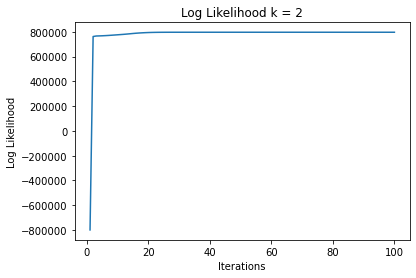

K =  3


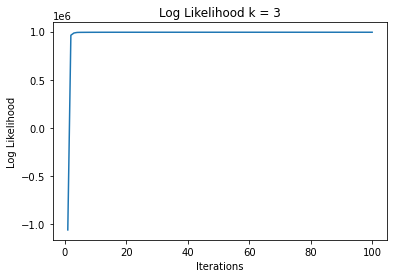

K =  7


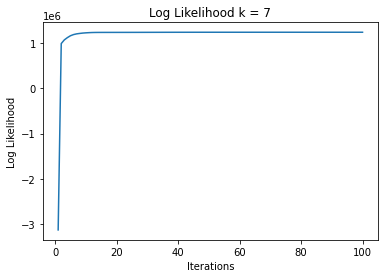

K =  20


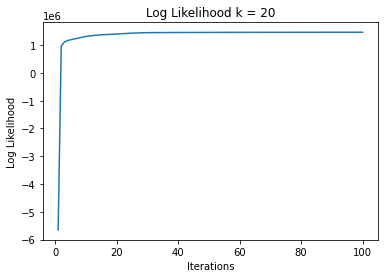

In [18]:
np.random.seed(42)
k_slot = [2, 3, 7, 20]
likelihood_store = []
for k_idx in k_slot:
    k = KMeans(K=k_idx, max_iters=100)
    print("K = ", k_idx)
    pixel_values = gmm_preprocess(image)
    y_pred = k.predict(pixel_values)
    model_GMM = GaussianMixture(k=k_idx, max_iter=100)
    pi, mu, cov = model_GMM.init(pixel_values, parameters=(np.uint8(k.cent()), y_pred))
    likelihood = model_GMM.EM(pi, mu, cov)
    # normalize likelihood
    likelihood = likelihood / np.sum(likelihood, axis=0)
    plot_loglikelihood(model_GMM)

<center>
    <table>
        <tr>
            <th>    
                K
            </th>
            <th>
                Log likelihood
            </th>
        </tr>
        <tr>
            <td>
                2
            </td>
            <td>
                <img src = "./image/log_2.png">
            </td>
        </tr>
        <tr>
            <td>
                3
            </td>
            <td>
               <img src = "./image/log_3.png">
            </td>
        </tr>
        <tr>
            <td>
                7
            </td>
            <td>
                <img src = "./image/log_7.png">
            </td>
        </tr>
        <tr>
            <td>
                20
            </td>
            <td>
                <img src = "./image/log_20.png">
            </td>
        </tr>
    </table>
</center>

#### 2.3

Repeat steps 1 and 2 for $K = 2, 3, 7$ and $20$. Please show the resulting images of $K$-means model and GMM, respectively. 

Below are some examples.

<center>
    <img src = "./image/figure2.png" width = 50%>
    <br><br>
    <table>
        <tr>
            <th>    
                &#9996
            </th>
            <th>
                K-means
            </th>
            <th>
                GMM
            </th>
        </tr>
        <tr>
            <td>
                <b>k = 2</b>
            </td>
            <td>
                <img src = "./image/kmeans_2.png">
            </td>
            <td>
                <img src = "./image/gmm_2.png">
            </td>
            </td>
        </tr>
        <tr>
            <td>
                <b>k = 3</b>
            </td>
            <td>
                <img src = "./image/kmeans_3.png">
            </td>
            <td>
                <img src = "./image/gmm_3.png">
            </td>
            </td>
        </tr>
        <tr>
            <td>
                <b>k = 7</b>
            </td>
            <td>
                <img src = "./image/kmeans_7.png">
            </td>
            <td>
                <img src = "./image/gmm_7.png">
            </td>
            </td>
        </tr>
        <tr>
            <td>
                <b>k = 20</b>
            </td>
            <td>
                <img src = "./image/kmeans_20.png">
            </td>
            <td>
                <img src = "./image/gmm_20.png">
            </td>
            </td>
        </tr>
</center>

K =  2


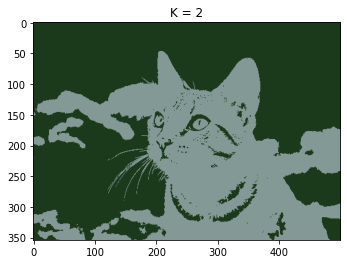

K =  3


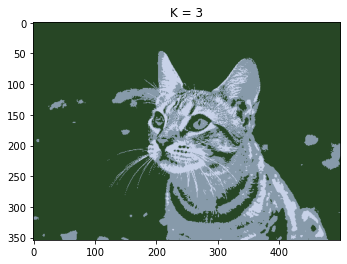

K =  7


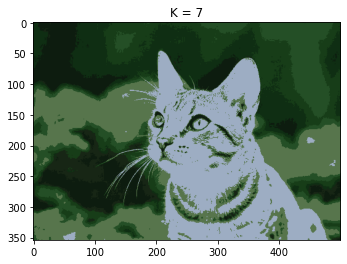

K =  20


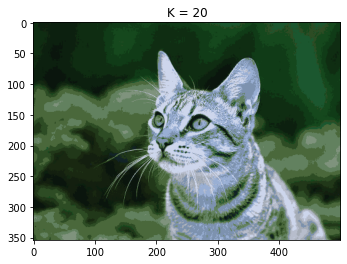

In [19]:
for k_idx in k_slot:
    k = KMeans(K=k_idx, max_iters=100)
    print("K = ", k_idx)
    pixel_values = kmeans_preprocess(image)
    y_pred = k.predict(pixel_values)
    centers = np.uint8(k.cent())
    # print center values with RGB format
    y_pred = y_pred.astype(int)
    labels = y_pred.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    # plot the image
    plt.title("K = " + str(k_idx))
    plt.imshow(segmented_image)
    plt.show()

K =  2


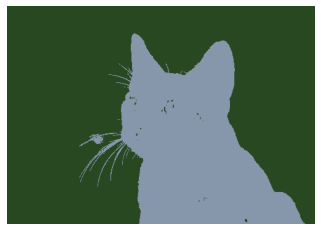

K =  3


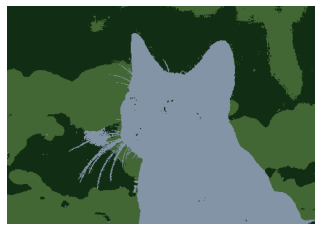

K =  7


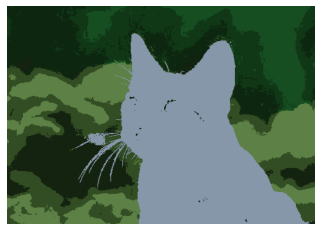

K =  20


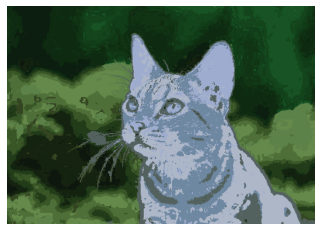

In [20]:
for k_idx in k_slot:
    k = KMeans(K=k_idx, max_iters=100)
    print("K = ", k_idx)
    pixel_values = gmm_preprocess(image)
    y_pred = k.predict(pixel_values)
    model_GMM = GaussianMixture(k=k_idx, max_iter=100)
    pi, mu, cov = model_GMM.init(pixel_values, parameters=(np.uint8(k.cent()), y_pred))
    likelihood = model_GMM.EM(pi, mu, cov)
    # normalize likelihood
    likelihood = likelihood / np.sum(likelihood, axis=0)
    model_GMM.plot_image(image, likelihood)

#### 2.4

Make some discussion about what is crucial factor to affect the output image between $K$-means and Gaussian mixture model (GMM), and explain the reason.

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

The main difference between K-means and Gaussian mixture model (GMM) is the <span class="red">assumption they make about the distribution of the data</span>.

##### $K$-means

K-means assumes that the data is <span class="blue">uniformly distributed within spherical clusters</span>. 

It tries to find clusters by minimizing the sum of squared distances between each point and the center of its assigned cluster. 

This means that K-means is <span class="blue">sensitive to the initial placement of the cluster centers, and can be affected by outliers</span>.

##### Gaussian mixture model (GMM)

On the other hand, GMM assumes that the data is <span class="blue">distributed according to a mixture of multiple Gaussian distributions</span>. 

It tries to find the parameters of these distributions that best fit the data. 

This means that GMM is <span class="blue">more robust to outliers</span>, as they are less likely to significantly influence the fit of the model.

##### Both crucial factor for output image

One important factor that can affect the output of both K-means and GMM is <span class="blue">the number of clusters that is chosen</span>. 

In K-means, choosing a large number of clusters may result in overfitting, while choosing a small number may result in underfitting. 

In GMM, choosing a large number of clusters may result in a complex model that is difficult to interpret, 

while choosing a small number may result in a simple model that is not able to capture the complexity of the data.

##### Conclusion

Overall, the choice of clustering algorithm and the number of clusters will <span class="red">depend on the specific characteristics of the data and the goals of the analysis</span>.

#### 2.5

The input image shown below comes from the licence-free dataset for personal and commercial use. 

Image from: https://pickupimage.com/free-photos/Cat-in-the-forest/2333003

<center>
    <img src = "./image/figure3.png" width = 30%>
</center>